In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from pathlib import Path

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import torch
import random

## Helper functions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


In [4]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [5]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [6]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'}, annot_kws={'size': 11})

        ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

### Load the datasets

In [7]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [8]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

## K-MEANS

In [9]:
# Function to compute SSE (Sum of Squared Errors)
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels):
    
    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1
    
    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)
    
    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples



    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    plt.close()
    return


In [10]:
# ...existing code...
def plot_attack_label_distribution_by_cluster(cluster_labels, attack_labels, top_n=None, normalize=False):
    classes = ['dos', 'normal', 'probe', 'r2l']
    data = pd.DataFrame({"cluster": cluster_labels, "attack_label": attack_labels})
    dist = pd.crosstab(data["cluster"], data["attack_label"])

    if top_n is not None and top_n < dist.shape[1]:
        top_cols = dist.sum().sort_values(ascending=False).head(top_n).index
        other = dist.drop(columns=top_cols).sum(axis=1)
        dist = dist[top_cols]
        dist["Other"] = other

    plot_df = dist.div(dist.sum(axis=1), axis=1) * 100 if normalize else dist
    unit = "%" if normalize else "count"

    fig, ax = plt.subplots(figsize=(12, 6))
    plot_df.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")
    ax.set_title("Attack label distribution across clusters", fontsize=14, fontweight="bold")
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_ylabel(f"Attack label share ({unit})", fontsize=12)
    ax.legend(title="Attack label", bbox_to_anchor=(1.02, 1), loc="upper left",labels=classes)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

## K-means cluster interpretation

Encoded Labels: ['dos', 'normal', 'probe', 'r2l']

In [11]:
for random_state in [42, 7, 21, 111]:
    # Set number of clusters
    kmeans = KMeans(n_clusters=4, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(X_train)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_

    sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
    silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

    print(f"K-Means SSE: {sse_avg:.2f}")
    print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
    plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels)

    plot_attack_label_distribution_by_cluster(cluster_labels, y_original_train, top_n=8, normalize=False)

KeyboardInterrupt: 

In [ ]:
silhouette_avg, cluster_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

cluster_silhouette_df = (
    pd.DataFrame({
        "cluster": list(cluster_silhouettes.keys()),
        "silhouette": list(cluster_silhouettes.values())
    })
    .sort_values("silhouette", ascending=False)
    .reset_index(drop=True)
)

print(cluster_silhouette_df)


low_silhouette_clusters = cluster_silhouette_df[cluster_silhouette_df["silhouette"] < silhouette_avg]
if not low_silhouette_clusters.empty:

    attack_dist = (
        pd.DataFrame({"cluster": kmeans_labels, "attack_label": y_original_train})
        .groupby("cluster")["attack_label"]
        .value_counts()
        .rename("count")
        .reset_index()
    )

    merged = low_silhouette_clusters.merge(attack_dist, on="cluster", how="left")
    print("\nAttack labels inside low-silhouette clusters:")
    print(merged.sort_values(["silhouette", "count"], ascending=[True, False]))


   cluster  silhouette
0        1    0.736899
1        2    0.483863
2        3    0.250312
3        0   -0.090384

Attack labels inside low-silhouette clusters:
   cluster  silhouette  attack_label  count
3        0   -0.090384             1   3015
4        0   -0.090384             0    628
5        0   -0.090384             2    306
6        0   -0.090384             3     55
0        3    0.250312             2    946
1        3    0.250312             1    483
2        3    0.250312             0    317


## TSNE

In [ ]:
def plot_tsne(df,cluster_labels,perplexity=30):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    print(f"\nGenerating t-SNE plot with perplexity={perplexity}...")

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df)
    labels = cluster_labels

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()
    
    return


Generating t-SNE plot with perplexity=5...


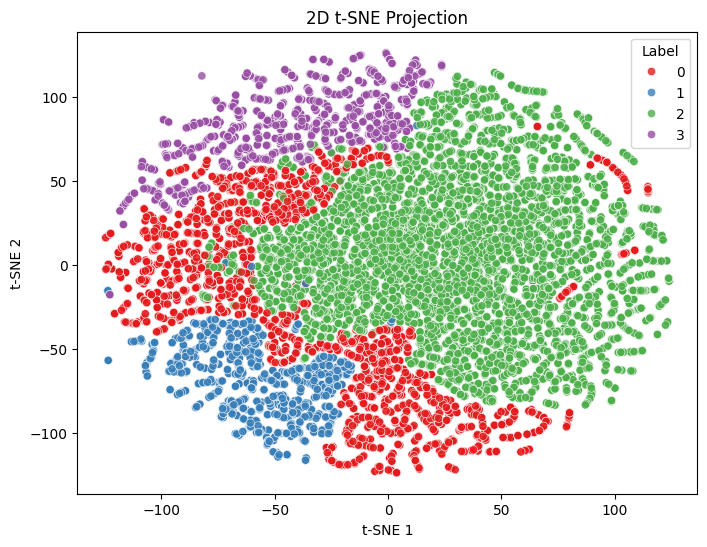


Generating t-SNE plot with perplexity=30...


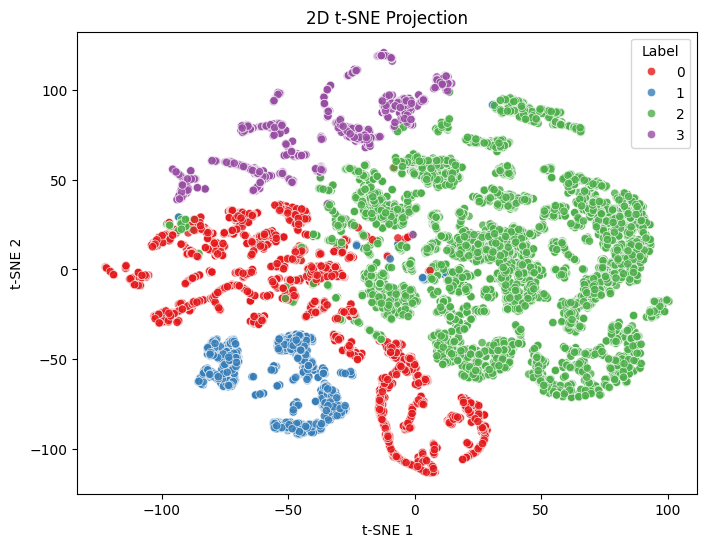


Generating t-SNE plot with perplexity=100...


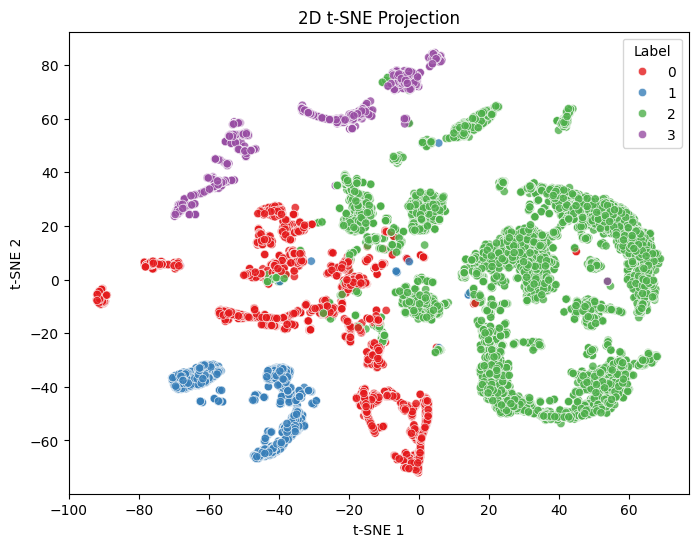

In [ ]:
for perplexity in [5,30,100]:
    plot_tsne(X_train, kmeans_labels, perplexity=perplexity)


Generating t-SNE plot with perplexity=30...


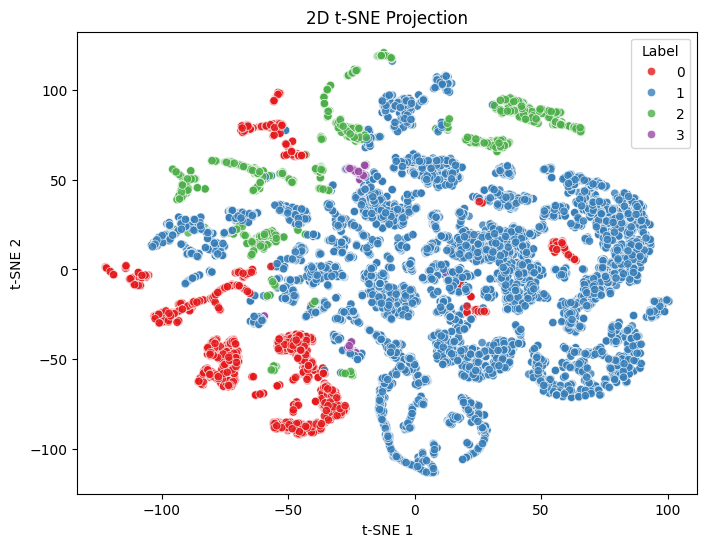

In [ ]:
plot_tsne(X_train, list(df_train['label']), perplexity=30)

## DB-SCAN

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# X = X_train.values.astype(float)
# cosine_matrix = cosine_similarity(X)

In [ ]:
# cosine_distances = 1.0 - cosine_matrix

# upper_tri = cosine_distances[np.triu_indices_from(cosine_distances, k=1)]
# sorted_distances = np.sort(upper_tri)
# cumulative_counts = np.arange(1, len(sorted_distances) + 1)

# plt.figure(figsize=(8, 4))
# plt.plot(sorted_distances, cumulative_counts, label="Cumulative count")
# plt.xlabel("Cosine distance")
# plt.ylabel("Number of point pairs ≤ distance")
# plt.title("Cumulative distribution of pairwise cosine distances")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.legend()
# plt.show()

In [ ]:
# # take the min_points-th neighbor distance (skip self-distance at 0)
# k_distances = np.sort(cosine_distances, axis=1)[:, min_points]
# k_distances_sorted = np.sort(k_distances)

# plt.figure(figsize=(8, 4))
# plt.plot(k_distances_sorted)
# plt.xlabel("Points sorted by distance")
# plt.ylabel(f"{min_points}-NN cosine distance")
# plt.title("k-distance plot (cosine metric)")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.show()

In [ ]:
# # THIS IS A METHOD TO FIND THE BEST EPS AND BEST MIN_SAMPLES
# # For min_samples, some sources say that it should be 2 * number of features. We try different values up to that value
# # For eps, we use the k-nearest neighbors distances. The best eps should be near the "knee" of the graph 
# # (the point which separates the noise (steep slope) from the clusters (flatter slope))
# if dbscan_alt_method:
#     min_samples_values = np.linspace(
#         5, 2 * df.shape[1], 3, dtype=int
#     )

#     # knn distances graph to find the best eps
#     # compute the knn distances for min_samples_values
#     knn_distances = []
#     for min_samples in min_samples_values:
#         k = min_samples - 1
#         neigh = NearestNeighbors(n_neighbors=k)
#         neigh.fit(df)
#         distances, _ = neigh.kneighbors(df)
#         distances = np.sort(distances, axis=0)
#         distances = distances[:, k-1]

#         # plot
#         plt.plot(distances)
#         plt.xlim(50000, 70000)
#         plt.ylim(0, 40)
#         plt.xlabel("Samples")
#         plt.ylabel(f"{k}th nearest neighbor distance")
#         plt.yticks(np.arange(0, 41, 2))
#         plt.title(f"k={k}")
#         plt.grid()
#         plt.show()
#         knn_distances.append(distances)

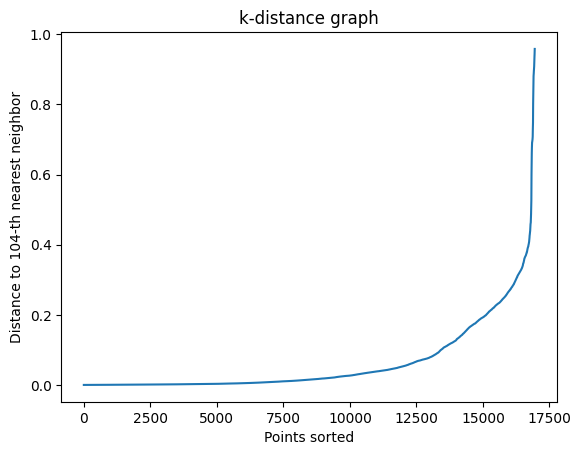

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# df = your dataframe with numeric features
X = X_train.values

# Step 1: choose min_samples
min_samples = X.shape[1] * 2  # heuristic

# Step 2: compute k-distances
neighbors = NearestNeighbors(n_neighbors=min_samples, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Step 3: take the k-th nearest neighbor distance
k_distances = np.sort(distances[:, -1])

# Step 4: plot
plt.plot(k_distances)
plt.xlabel("Points sorted")
plt.ylabel(f"Distance to {min_samples}-th nearest neighbor")
plt.title("k-distance graph")
plt.show()

# The elbow region gives you eps.

In [13]:
min_samples

104


Running DBSCAN with eps=0.7, min_samples=50...

Classification Report (DBSCAN eps=0.7, min_samples=50 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.77      0.71      0.74     12102
     Anomaly       0.39      0.46      0.42      4845

    accuracy                           0.64     16947
   macro avg       0.58      0.59      0.58     16947
weighted avg       0.66      0.64      0.65     16947



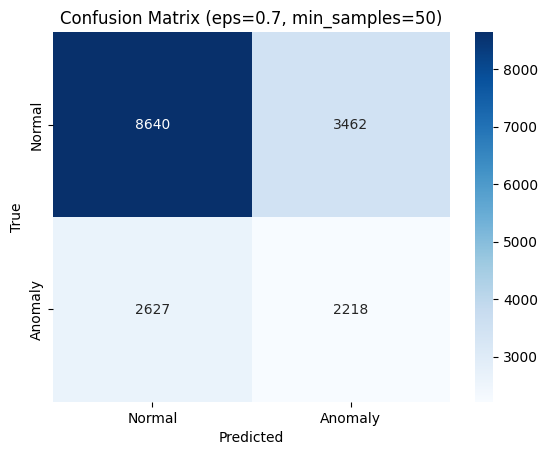


Running DBSCAN with eps=0.7, min_samples=100...

Classification Report (DBSCAN eps=0.7, min_samples=100 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.78      0.64      0.70     12102
     Anomaly       0.38      0.55      0.45      4845

    accuracy                           0.61     16947
   macro avg       0.58      0.59      0.58     16947
weighted avg       0.67      0.61      0.63     16947



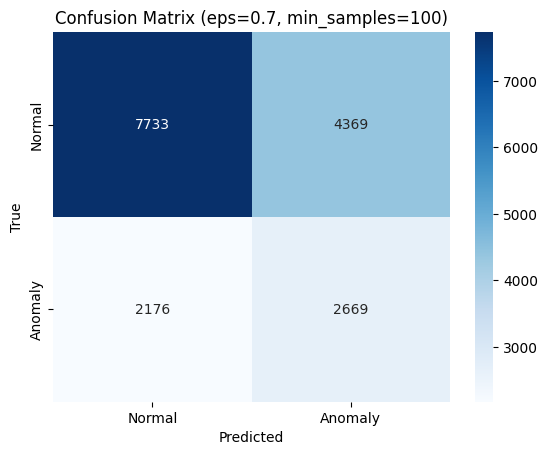


Running DBSCAN with eps=0.7, min_samples=150...

Classification Report (DBSCAN eps=0.7, min_samples=150 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.60      0.69     12102
     Anomaly       0.39      0.65      0.49      4845

    accuracy                           0.61     16947
   macro avg       0.60      0.62      0.59     16947
weighted avg       0.69      0.61      0.63     16947



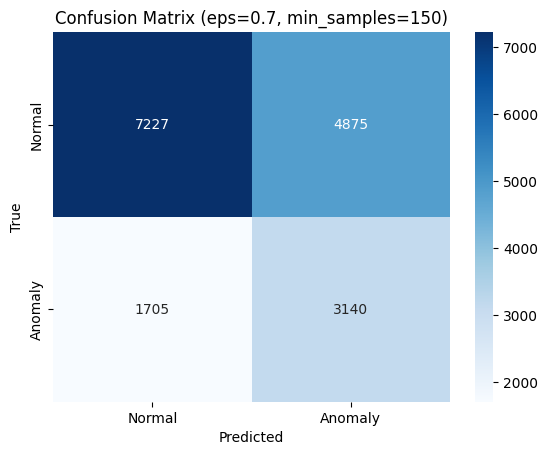


Running DBSCAN with eps=0.7, min_samples=200...

Classification Report (DBSCAN eps=0.7, min_samples=200 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.54      0.64     12102
     Anomaly       0.36      0.65      0.46      4845

    accuracy                           0.57     16947
   macro avg       0.58      0.59      0.55     16947
weighted avg       0.67      0.57      0.59     16947



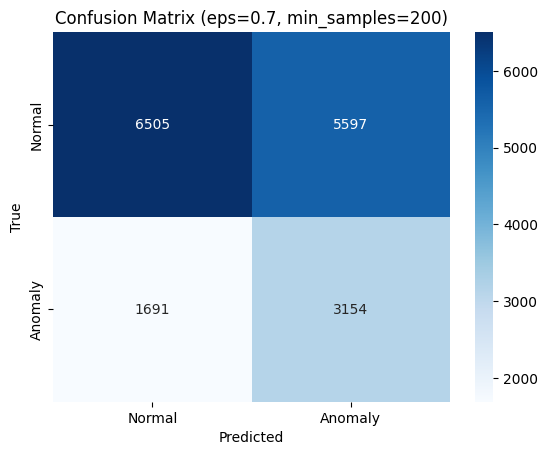


Running DBSCAN with eps=0.7, min_samples=250...

Classification Report (DBSCAN eps=0.7, min_samples=250 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.53      0.64     12102
     Anomaly       0.36      0.66      0.46      4845

    accuracy                           0.57     16947
   macro avg       0.58      0.59      0.55     16947
weighted avg       0.67      0.57      0.59     16947



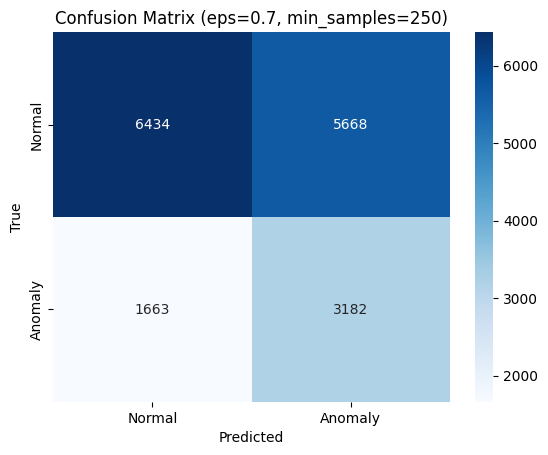


Running DBSCAN with eps=0.7, min_samples=300...

Classification Report (DBSCAN eps=0.7, min_samples=300 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.53      0.64     12102
     Anomaly       0.37      0.69      0.48      4845

    accuracy                           0.57     16947
   macro avg       0.59      0.61      0.56     16947
weighted avg       0.68      0.57      0.59     16947



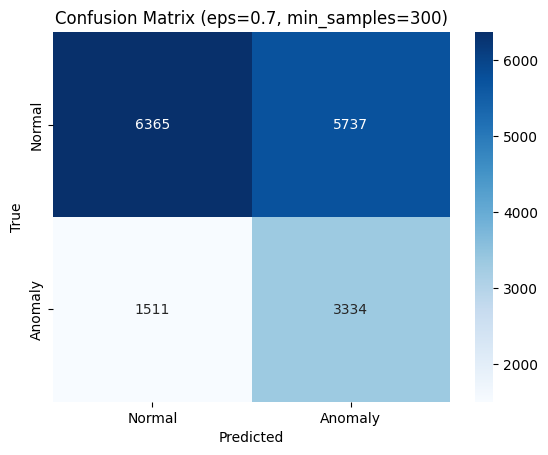


Running DBSCAN with eps=0.7, min_samples=350...

Classification Report (DBSCAN eps=0.7, min_samples=350 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.52      0.65     12102
     Anomaly       0.41      0.84      0.55      4845

    accuracy                           0.61     16947
   macro avg       0.65      0.68      0.60     16947
weighted avg       0.75      0.61      0.63     16947



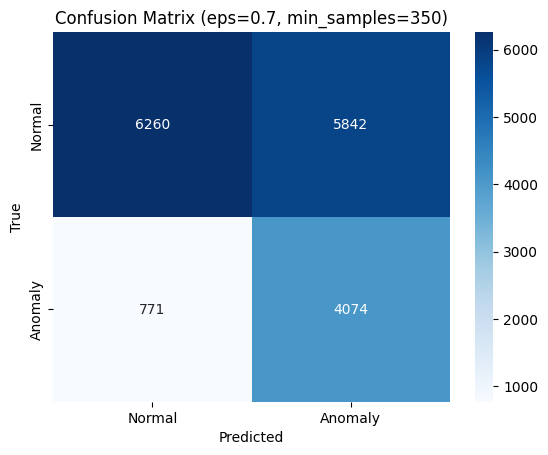


Running DBSCAN with eps=0.7, min_samples=400...

Classification Report (DBSCAN eps=0.7, min_samples=400 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.51      0.65     12102
     Anomaly       0.41      0.84      0.55      4845

    accuracy                           0.61     16947
   macro avg       0.65      0.68      0.60     16947
weighted avg       0.75      0.61      0.62     16947



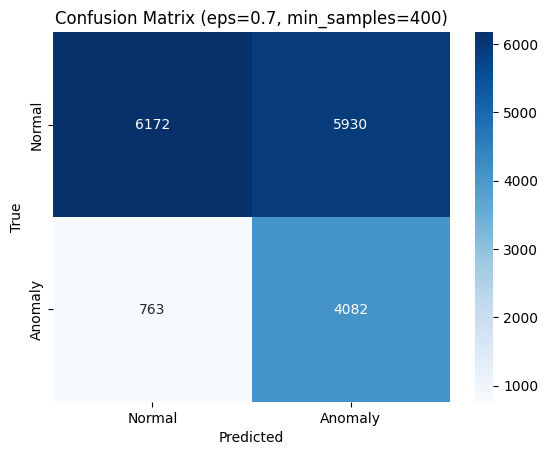


Running DBSCAN with eps=0.7, min_samples=450...

Classification Report (DBSCAN eps=0.7, min_samples=450 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.51      0.65     12102
     Anomaly       0.41      0.85      0.55      4845

    accuracy                           0.60     16947
   macro avg       0.65      0.68      0.60     16947
weighted avg       0.75      0.60      0.62     16947



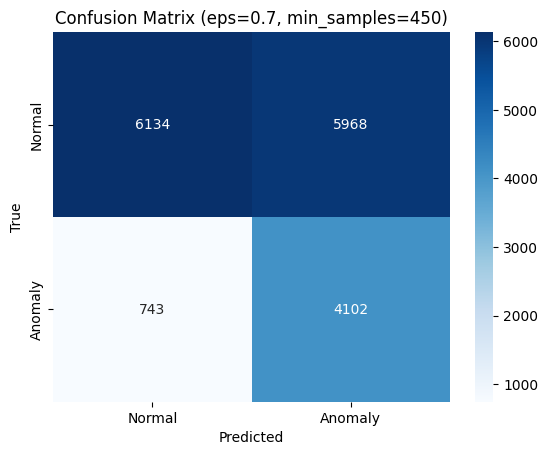


Running DBSCAN with eps=0.7, min_samples=500...

Classification Report (DBSCAN eps=0.7, min_samples=500 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.92      0.50      0.65     12102
     Anomaly       0.42      0.89      0.57      4845

    accuracy                           0.61     16947
   macro avg       0.67      0.70      0.61     16947
weighted avg       0.78      0.61      0.63     16947



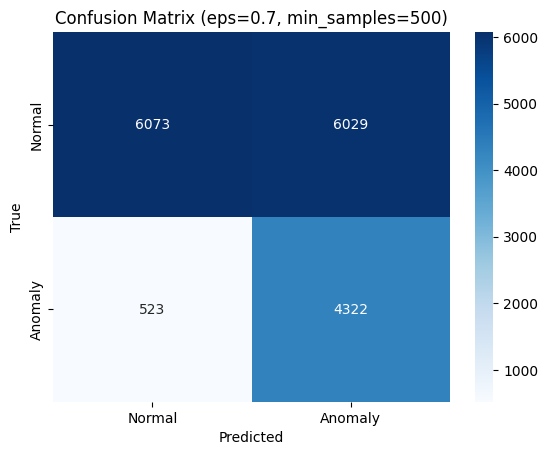


Running DBSCAN with eps=0.9, min_samples=50...

Classification Report (DBSCAN eps=0.9, min_samples=50 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.76      0.77      0.76     12102
     Anomaly       0.40      0.39      0.40      4845

    accuracy                           0.66     16947
   macro avg       0.58      0.58      0.58     16947
weighted avg       0.66      0.66      0.66     16947



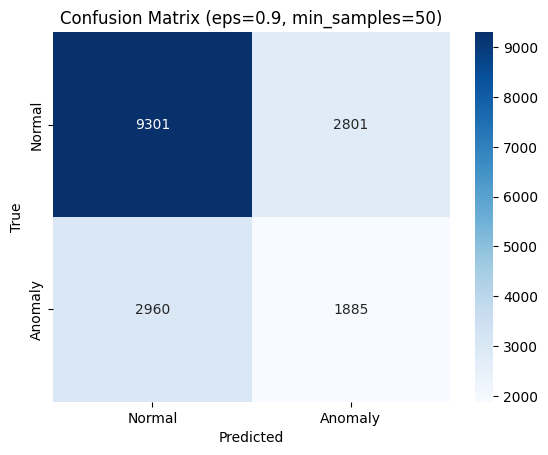


Running DBSCAN with eps=0.9, min_samples=100...

Classification Report (DBSCAN eps=0.9, min_samples=100 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.78      0.71      0.74     12102
     Anomaly       0.41      0.50      0.45      4845

    accuracy                           0.65     16947
   macro avg       0.59      0.60      0.59     16947
weighted avg       0.67      0.65      0.66     16947



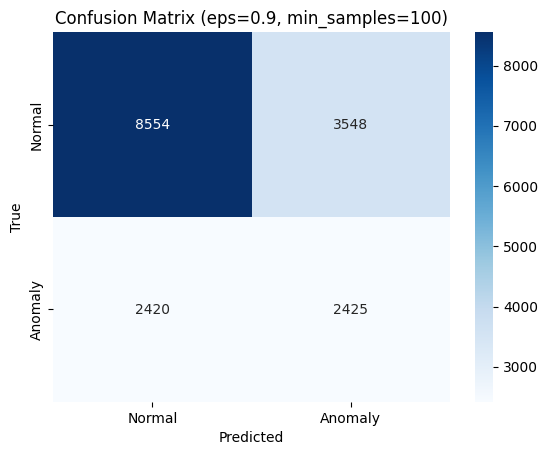


Running DBSCAN with eps=0.9, min_samples=150...

Classification Report (DBSCAN eps=0.9, min_samples=150 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.82      0.67      0.73     12102
     Anomaly       0.43      0.63      0.51      4845

    accuracy                           0.66     16947
   macro avg       0.62      0.65      0.62     16947
weighted avg       0.71      0.66      0.67     16947



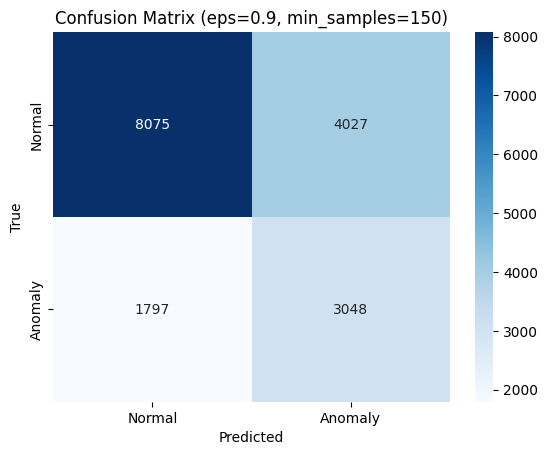


Running DBSCAN with eps=0.9, min_samples=200...

Classification Report (DBSCAN eps=0.9, min_samples=200 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.63      0.71     12102
     Anomaly       0.41      0.63      0.49      4845

    accuracy                           0.63     16947
   macro avg       0.61      0.63      0.60     16947
weighted avg       0.69      0.63      0.65     16947



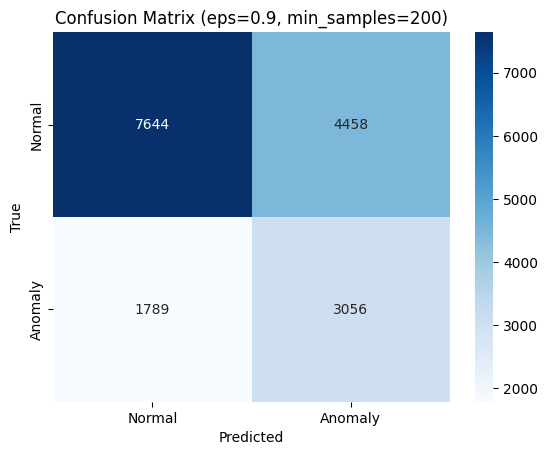


Running DBSCAN with eps=0.9, min_samples=250...

Classification Report (DBSCAN eps=0.9, min_samples=250 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.60      0.69     12102
     Anomaly       0.39      0.64      0.49      4845

    accuracy                           0.61     16947
   macro avg       0.60      0.62      0.59     16947
weighted avg       0.69      0.61      0.63     16947



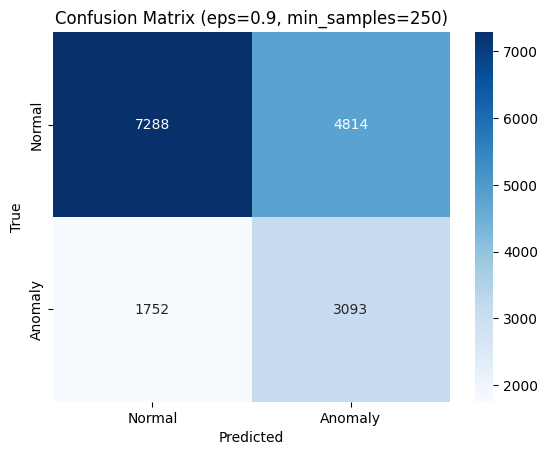


Running DBSCAN with eps=0.9, min_samples=300...

Classification Report (DBSCAN eps=0.9, min_samples=300 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.56      0.66     12102
     Anomaly       0.37      0.64      0.47      4845

    accuracy                           0.58     16947
   macro avg       0.58      0.60      0.56     16947
weighted avg       0.67      0.58      0.60     16947



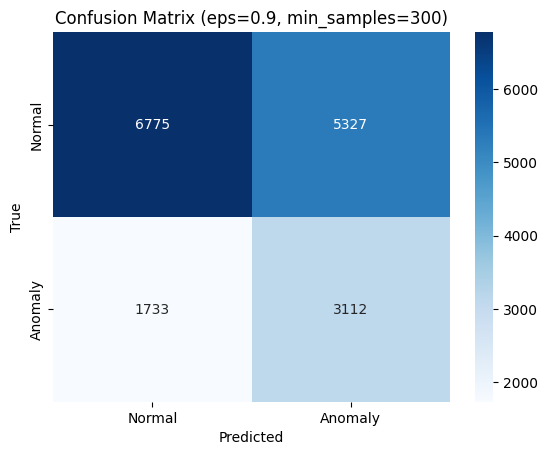


Running DBSCAN with eps=0.9, min_samples=350...

Classification Report (DBSCAN eps=0.9, min_samples=350 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.56      0.66     12102
     Anomaly       0.37      0.65      0.47      4845

    accuracy                           0.58     16947
   macro avg       0.58      0.60      0.56     16947
weighted avg       0.68      0.58      0.60     16947



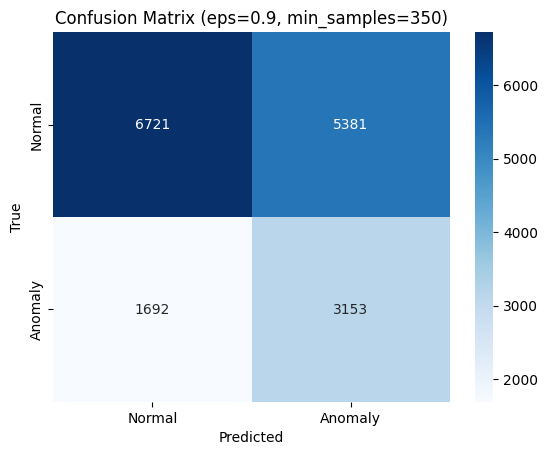


Running DBSCAN with eps=0.9, min_samples=400...

Classification Report (DBSCAN eps=0.9, min_samples=400 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.55      0.68     12102
     Anomaly       0.43      0.83      0.56      4845

    accuracy                           0.63     16947
   macro avg       0.66      0.69      0.62     16947
weighted avg       0.76      0.63      0.65     16947



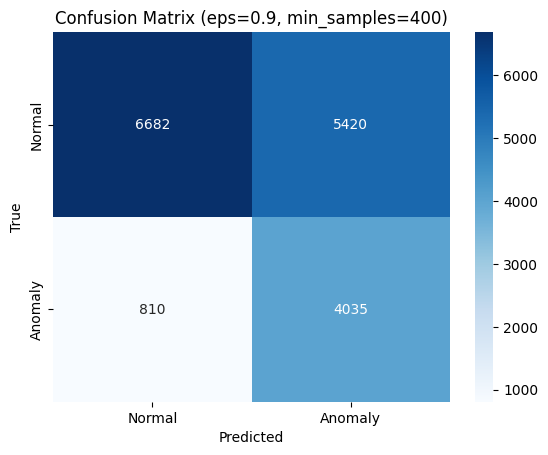


Running DBSCAN with eps=0.9, min_samples=450...

Classification Report (DBSCAN eps=0.9, min_samples=450 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.55      0.68     12102
     Anomaly       0.42      0.83      0.56      4845

    accuracy                           0.63     16947
   macro avg       0.66      0.69      0.62     16947
weighted avg       0.76      0.63      0.64     16947



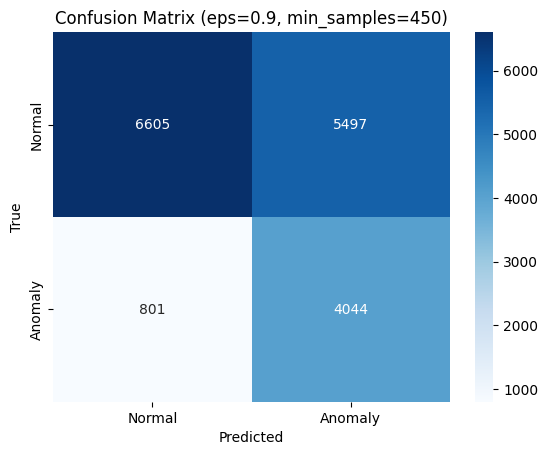


Running DBSCAN with eps=0.9, min_samples=500...

Classification Report (DBSCAN eps=0.9, min_samples=500 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.54      0.67     12102
     Anomaly       0.42      0.84      0.56      4845

    accuracy                           0.62     16947
   macro avg       0.66      0.69      0.62     16947
weighted avg       0.76      0.62      0.64     16947



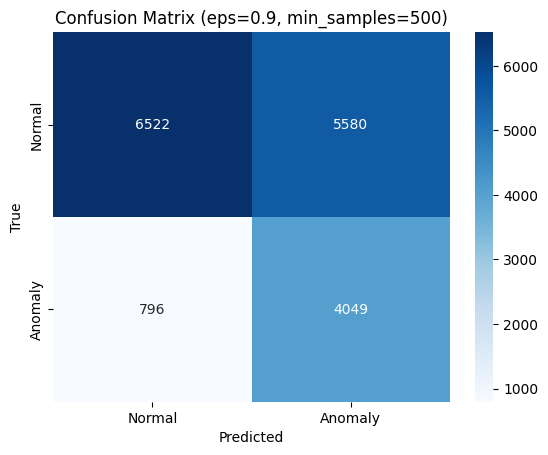


Running DBSCAN with eps=1.0, min_samples=50...

Classification Report (DBSCAN eps=1.0, min_samples=50 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.75      0.78      0.76     12102
     Anomaly       0.39      0.35      0.37      4845

    accuracy                           0.66     16947
   macro avg       0.57      0.56      0.57     16947
weighted avg       0.65      0.66      0.65     16947



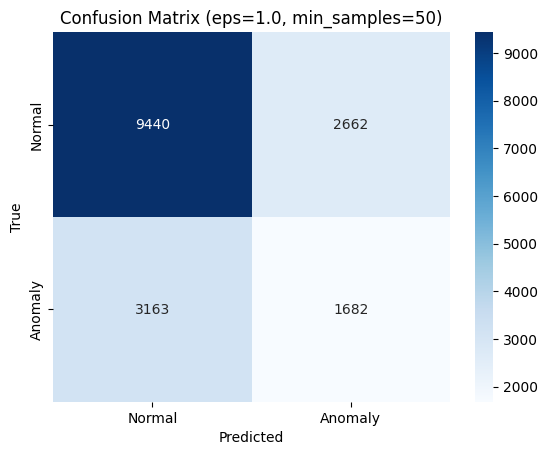


Running DBSCAN with eps=1.0, min_samples=100...

Classification Report (DBSCAN eps=1.0, min_samples=100 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.74      0.77     12102
     Anomaly       0.44      0.49      0.46      4845

    accuracy                           0.67     16947
   macro avg       0.61      0.62      0.61     16947
weighted avg       0.69      0.67      0.68     16947



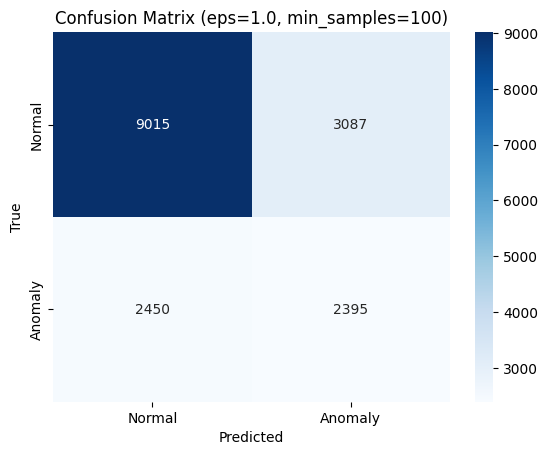


Running DBSCAN with eps=1.0, min_samples=150...

Classification Report (DBSCAN eps=1.0, min_samples=150 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.78      0.69      0.74     12102
     Anomaly       0.41      0.52      0.46      4845

    accuracy                           0.64     16947
   macro avg       0.59      0.61      0.60     16947
weighted avg       0.68      0.64      0.66     16947



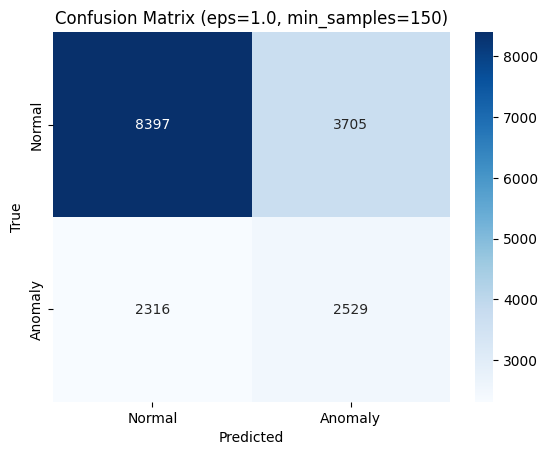


Running DBSCAN with eps=1.0, min_samples=200...

Classification Report (DBSCAN eps=1.0, min_samples=200 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.65      0.72     12102
     Anomaly       0.42      0.62      0.50      4845

    accuracy                           0.65     16947
   macro avg       0.62      0.64      0.61     16947
weighted avg       0.70      0.65      0.66     16947



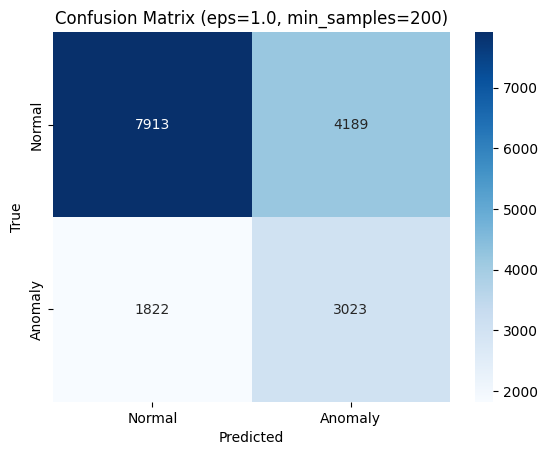


Running DBSCAN with eps=1.0, min_samples=250...

Classification Report (DBSCAN eps=1.0, min_samples=250 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.62      0.70     12102
     Anomaly       0.40      0.63      0.49      4845

    accuracy                           0.62     16947
   macro avg       0.60      0.62      0.59     16947
weighted avg       0.69      0.62      0.64     16947



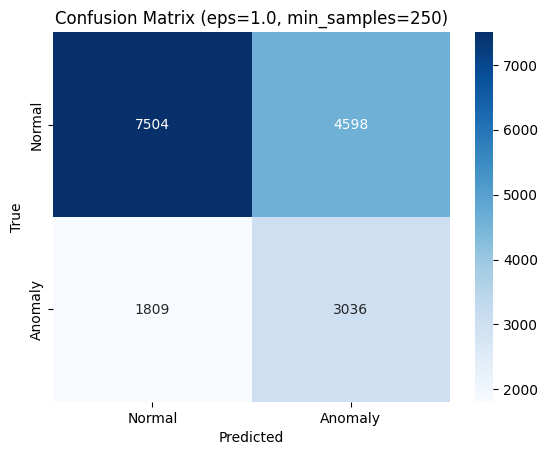


Running DBSCAN with eps=1.0, min_samples=300...

Classification Report (DBSCAN eps=1.0, min_samples=300 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.61      0.70     12102
     Anomaly       0.39      0.63      0.48      4845

    accuracy                           0.62     16947
   macro avg       0.60      0.62      0.59     16947
weighted avg       0.69      0.62      0.63     16947



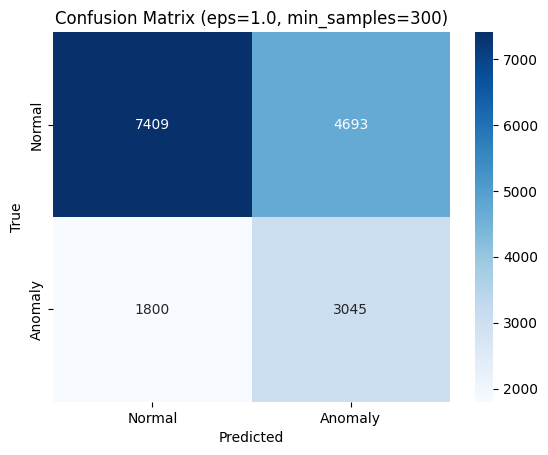


Running DBSCAN with eps=1.0, min_samples=350...

Classification Report (DBSCAN eps=1.0, min_samples=350 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.57      0.66     12102
     Anomaly       0.37      0.64      0.47      4845

    accuracy                           0.59     16947
   macro avg       0.59      0.60      0.57     16947
weighted avg       0.68      0.59      0.61     16947



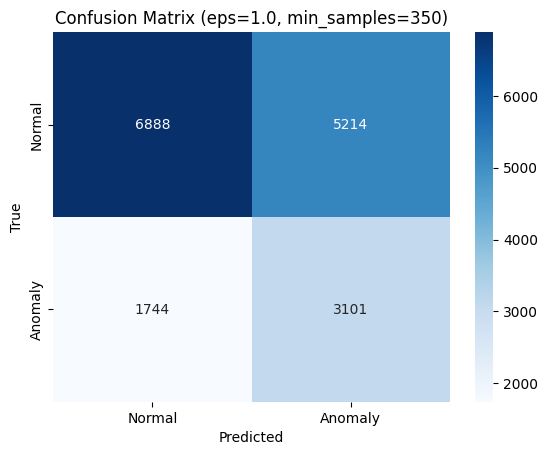


Running DBSCAN with eps=1.0, min_samples=400...

Classification Report (DBSCAN eps=1.0, min_samples=400 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.84      0.56      0.67     12102
     Anomaly       0.40      0.73      0.52      4845

    accuracy                           0.61     16947
   macro avg       0.62      0.65      0.60     16947
weighted avg       0.71      0.61      0.63     16947



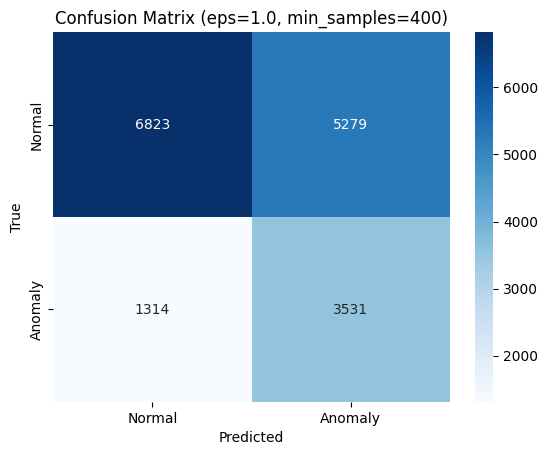


Running DBSCAN with eps=1.0, min_samples=450...

Classification Report (DBSCAN eps=1.0, min_samples=450 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.56      0.69     12102
     Anomaly       0.43      0.83      0.57      4845

    accuracy                           0.64     16947
   macro avg       0.66      0.69      0.63     16947
weighted avg       0.76      0.64      0.65     16947



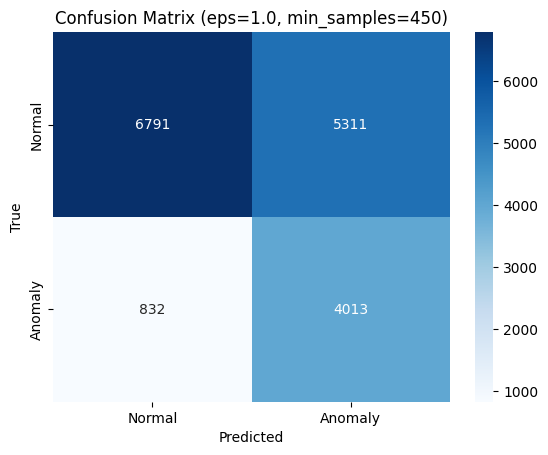


Running DBSCAN with eps=1.0, min_samples=500...

Classification Report (DBSCAN eps=1.0, min_samples=500 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.56      0.69     12102
     Anomaly       0.43      0.83      0.57      4845

    accuracy                           0.64     16947
   macro avg       0.66      0.69      0.63     16947
weighted avg       0.76      0.64      0.65     16947



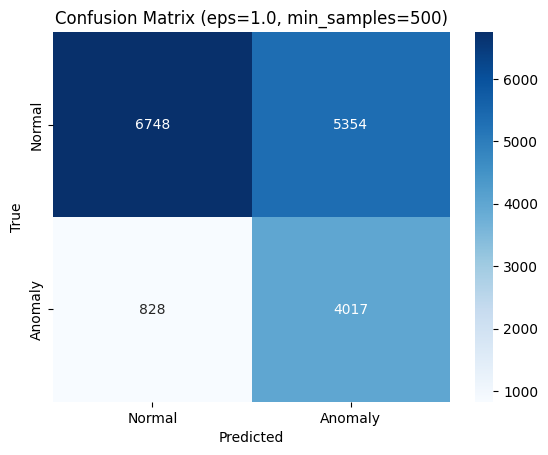


Running DBSCAN with eps=1.2, min_samples=50...

Classification Report (DBSCAN eps=1.2, min_samples=50 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.75      0.81      0.78     12102
     Anomaly       0.40      0.31      0.35      4845

    accuracy                           0.67     16947
   macro avg       0.57      0.56      0.56     16947
weighted avg       0.65      0.67      0.66     16947



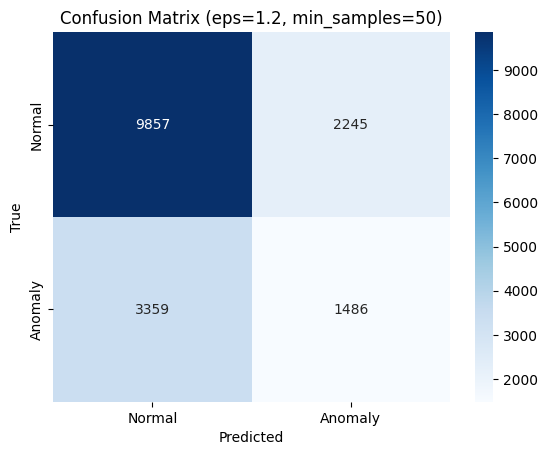


Running DBSCAN with eps=1.2, min_samples=100...

Classification Report (DBSCAN eps=1.2, min_samples=100 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.77      0.77      0.77     12102
     Anomaly       0.43      0.44      0.43      4845

    accuracy                           0.68     16947
   macro avg       0.60      0.60      0.60     16947
weighted avg       0.68      0.68      0.68     16947



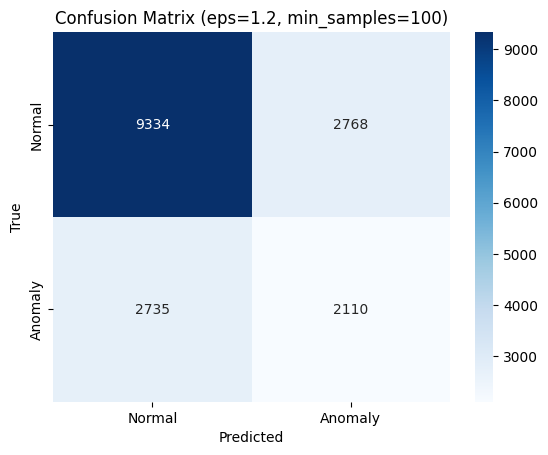


Running DBSCAN with eps=1.2, min_samples=150...

Classification Report (DBSCAN eps=1.2, min_samples=150 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.73      0.76     12102
     Anomaly       0.43      0.50      0.46      4845

    accuracy                           0.67     16947
   macro avg       0.61      0.62      0.61     16947
weighted avg       0.68      0.67      0.67     16947



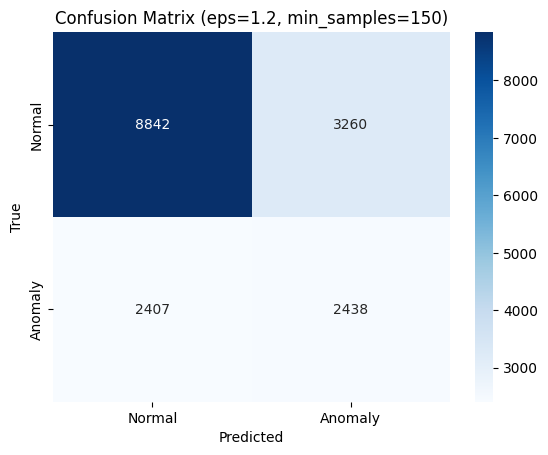


Running DBSCAN with eps=1.2, min_samples=200...

Classification Report (DBSCAN eps=1.2, min_samples=200 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.82      0.71      0.76     12102
     Anomaly       0.45      0.60      0.52      4845

    accuracy                           0.68     16947
   macro avg       0.63      0.65      0.64     16947
weighted avg       0.71      0.68      0.69     16947



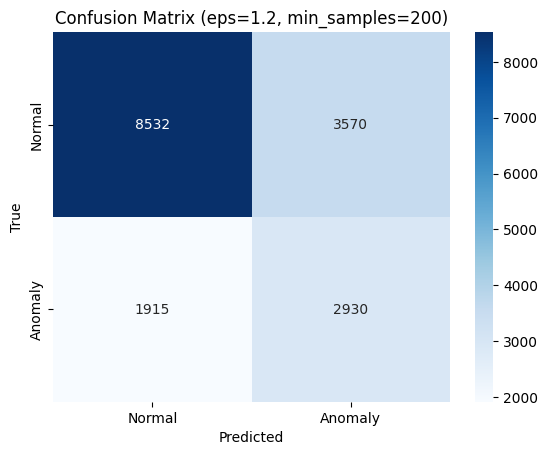


Running DBSCAN with eps=1.2, min_samples=250...

Classification Report (DBSCAN eps=1.2, min_samples=250 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.82      0.69      0.75     12102
     Anomaly       0.44      0.61      0.51      4845

    accuracy                           0.67     16947
   macro avg       0.63      0.65      0.63     16947
weighted avg       0.71      0.67      0.68     16947



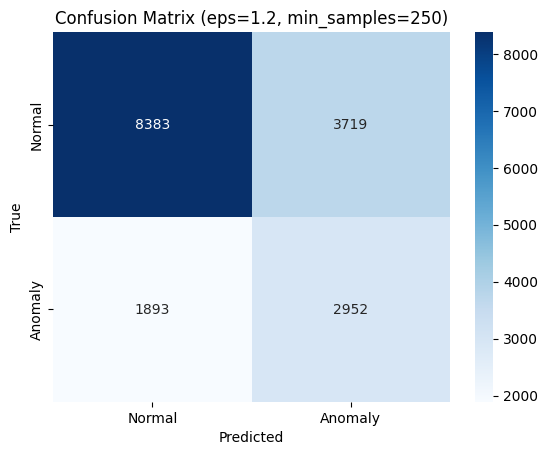


Running DBSCAN with eps=1.2, min_samples=300...

Classification Report (DBSCAN eps=1.2, min_samples=300 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.63      0.71     12102
     Anomaly       0.40      0.62      0.49      4845

    accuracy                           0.63     16947
   macro avg       0.60      0.62      0.60     16947
weighted avg       0.69      0.63      0.65     16947



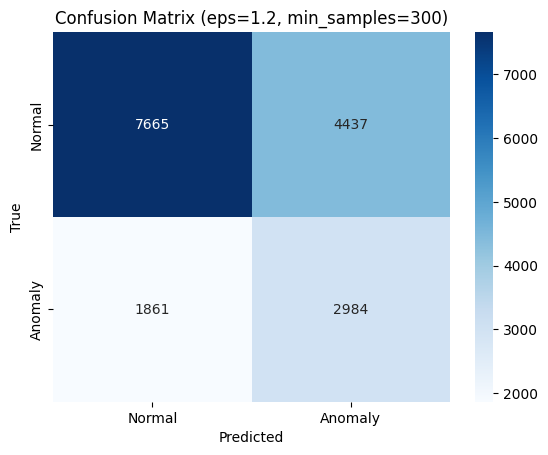


Running DBSCAN with eps=1.2, min_samples=350...

Classification Report (DBSCAN eps=1.2, min_samples=350 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.63      0.71     12102
     Anomaly       0.40      0.62      0.49      4845

    accuracy                           0.63     16947
   macro avg       0.60      0.63      0.60     16947
weighted avg       0.69      0.63      0.65     16947



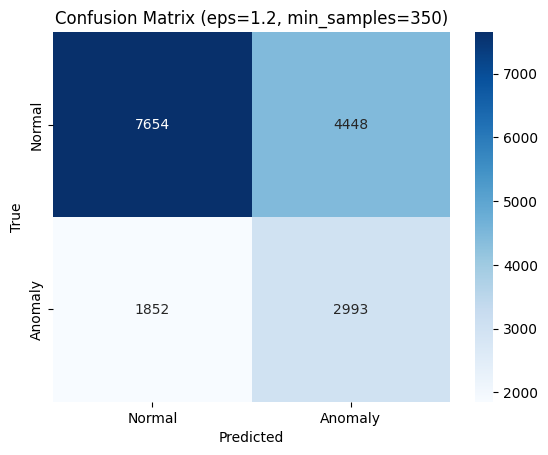


Running DBSCAN with eps=1.2, min_samples=400...

Classification Report (DBSCAN eps=1.2, min_samples=400 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.62      0.70     12102
     Anomaly       0.40      0.62      0.49      4845

    accuracy                           0.62     16947
   macro avg       0.60      0.62      0.59     16947
weighted avg       0.69      0.62      0.64     16947



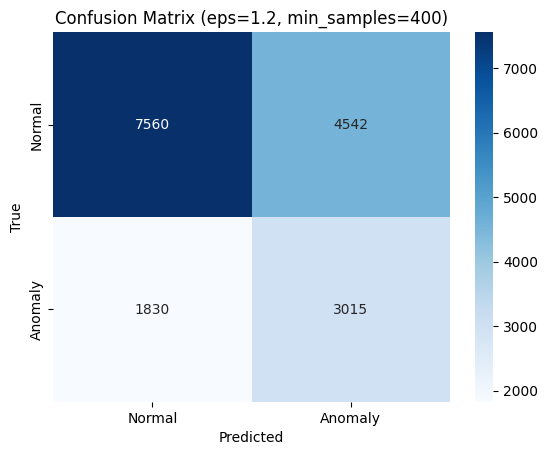


Running DBSCAN with eps=1.2, min_samples=450...

Classification Report (DBSCAN eps=1.2, min_samples=450 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.84      0.59      0.69     12102
     Anomaly       0.41      0.72      0.52      4845

    accuracy                           0.62     16947
   macro avg       0.62      0.65      0.61     16947
weighted avg       0.72      0.62      0.64     16947



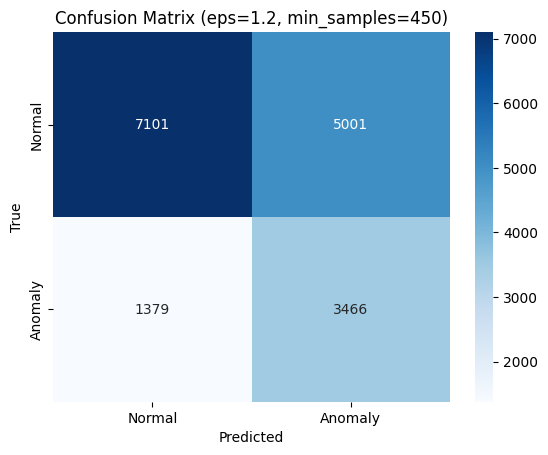


Running DBSCAN with eps=1.2, min_samples=500...

Classification Report (DBSCAN eps=1.2, min_samples=500 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.58      0.71     12102
     Anomaly       0.44      0.82      0.57      4845

    accuracy                           0.65     16947
   macro avg       0.66      0.70      0.64     16947
weighted avg       0.76      0.65      0.67     16947



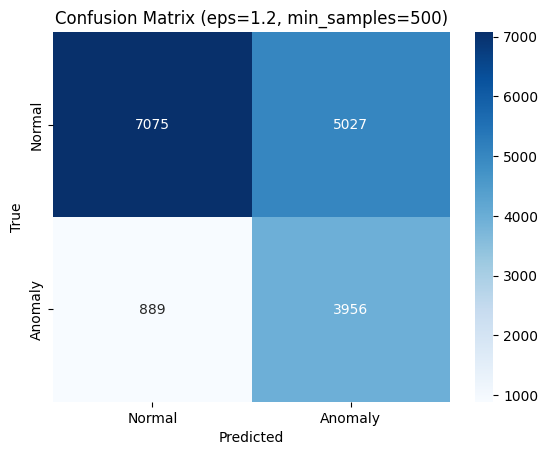


Running DBSCAN with eps=1.4, min_samples=50...

Classification Report (DBSCAN eps=1.4, min_samples=50 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.74      0.84      0.79     12102
     Anomaly       0.39      0.25      0.30      4845

    accuracy                           0.67     16947
   macro avg       0.56      0.55      0.54     16947
weighted avg       0.64      0.67      0.65     16947



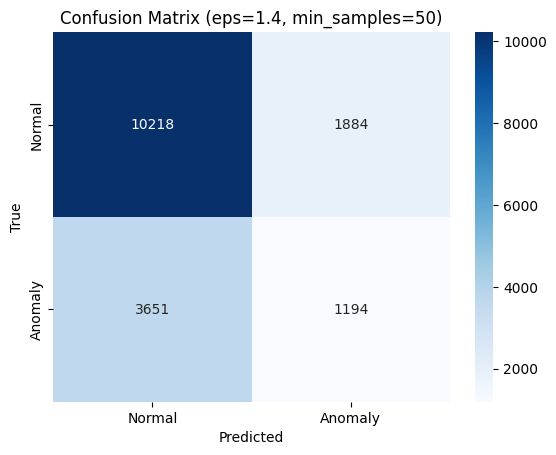


Running DBSCAN with eps=1.4, min_samples=100...

Classification Report (DBSCAN eps=1.4, min_samples=100 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.77      0.79      0.78     12102
     Anomaly       0.45      0.43      0.44      4845

    accuracy                           0.68     16947
   macro avg       0.61      0.61      0.61     16947
weighted avg       0.68      0.68      0.68     16947



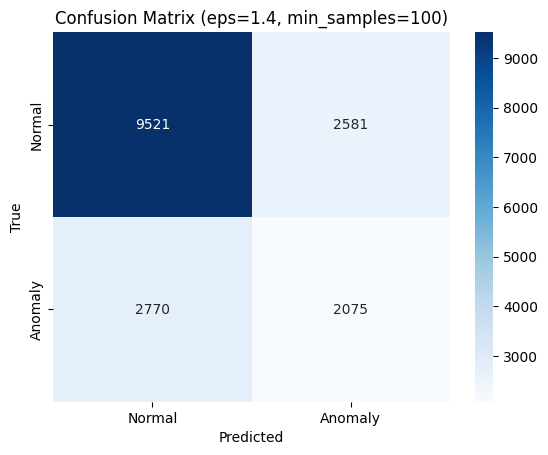


Running DBSCAN with eps=1.4, min_samples=150...

Classification Report (DBSCAN eps=1.4, min_samples=150 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.77      0.78     12102
     Anomaly       0.45      0.48      0.47      4845

    accuracy                           0.69     16947
   macro avg       0.62      0.62      0.62     16947
weighted avg       0.69      0.69      0.69     16947



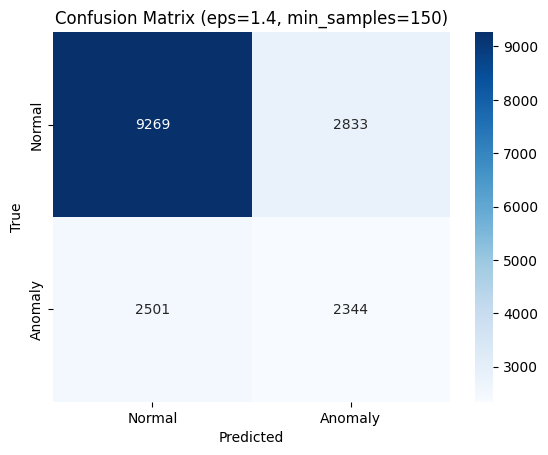


Running DBSCAN with eps=1.4, min_samples=200...

Classification Report (DBSCAN eps=1.4, min_samples=200 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.72      0.77     12102
     Anomaly       0.46      0.59      0.52      4845

    accuracy                           0.68     16947
   macro avg       0.64      0.66      0.64     16947
weighted avg       0.71      0.68      0.69     16947



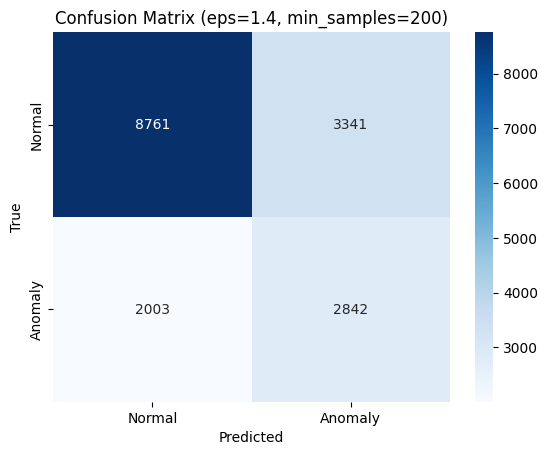


Running DBSCAN with eps=1.4, min_samples=250...

Classification Report (DBSCAN eps=1.4, min_samples=250 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.72      0.76     12102
     Anomaly       0.46      0.59      0.51      4845

    accuracy                           0.68     16947
   macro avg       0.64      0.65      0.64     16947
weighted avg       0.71      0.68      0.69     16947



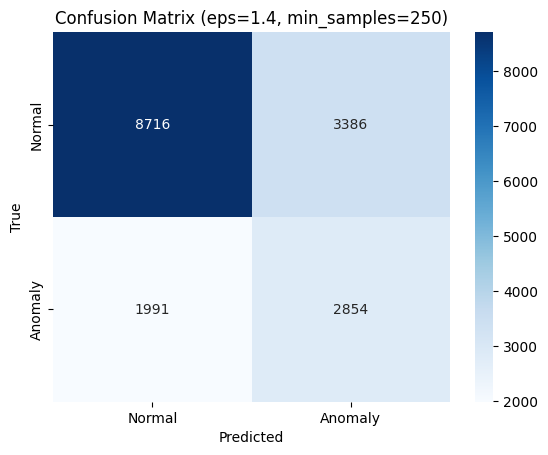


Running DBSCAN with eps=1.4, min_samples=300...

Classification Report (DBSCAN eps=1.4, min_samples=300 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.71      0.76     12102
     Anomaly       0.45      0.59      0.51      4845

    accuracy                           0.68     16947
   macro avg       0.63      0.65      0.64     16947
weighted avg       0.71      0.68      0.69     16947



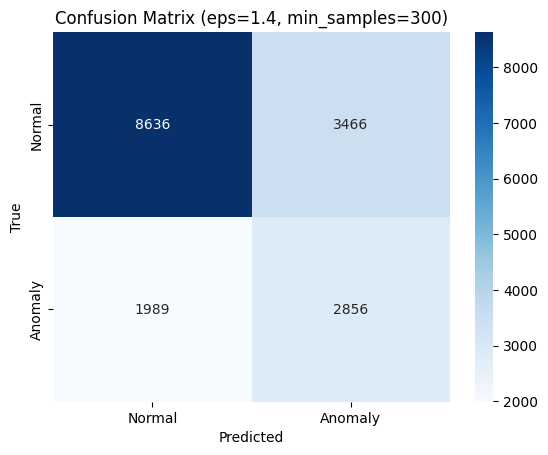


Running DBSCAN with eps=1.4, min_samples=350...

Classification Report (DBSCAN eps=1.4, min_samples=350 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.81      0.68      0.74     12102
     Anomaly       0.43      0.59      0.50      4845

    accuracy                           0.66     16947
   macro avg       0.62      0.64      0.62     16947
weighted avg       0.70      0.66      0.67     16947



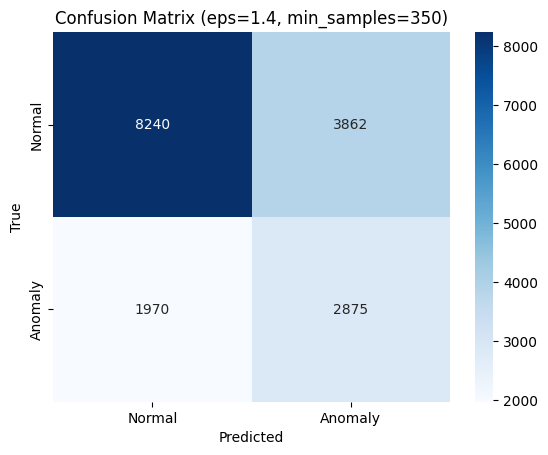


Running DBSCAN with eps=1.4, min_samples=400...

Classification Report (DBSCAN eps=1.4, min_samples=400 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.80      0.64      0.72     12102
     Anomaly       0.41      0.61      0.49      4845

    accuracy                           0.63     16947
   macro avg       0.61      0.63      0.60     16947
weighted avg       0.69      0.63      0.65     16947



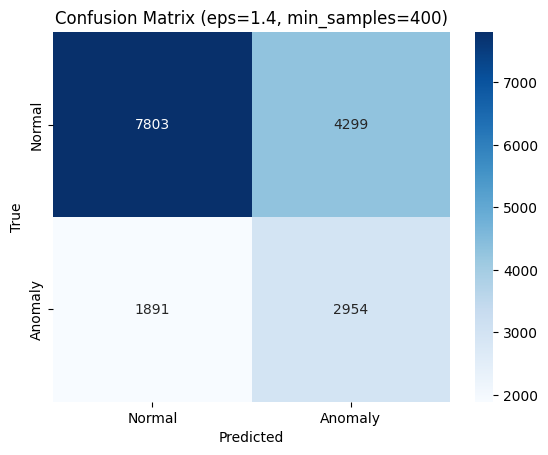


Running DBSCAN with eps=1.4, min_samples=450...

Classification Report (DBSCAN eps=1.4, min_samples=450 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.84      0.64      0.73     12102
     Anomaly       0.44      0.70      0.54      4845

    accuracy                           0.66     16947
   macro avg       0.64      0.67      0.63     16947
weighted avg       0.73      0.66      0.67     16947



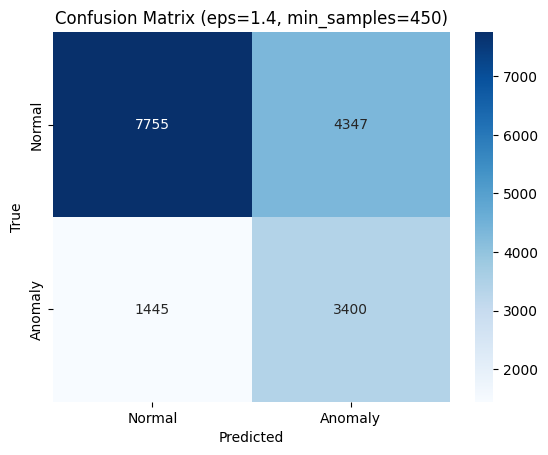


Running DBSCAN with eps=1.4, min_samples=500...

Classification Report (DBSCAN eps=1.4, min_samples=500 vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.89      0.59      0.71     12102
     Anomaly       0.44      0.81      0.57      4845

    accuracy                           0.66     16947
   macro avg       0.66      0.70      0.64     16947
weighted avg       0.76      0.66      0.67     16947



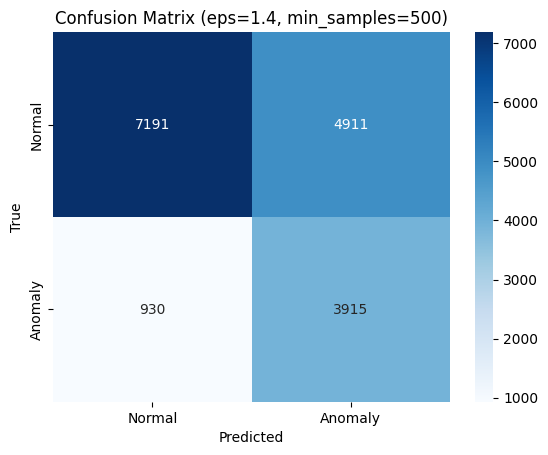

In [33]:
eps_values = [0.7, 0.9, 1.0, 1.2, 1.4]
min_samples_values = np.arange(50, 501, 50)

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nRunning DBSCAN with eps={eps}, min_samples={min_samples}...")
        # Use DBSCAN with the epsilon and min_points previosly defined
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_train)

        y_pred_binary_dbscan = [1 if label == -1 else 0 for label in dbscan_labels]

        print(f"\nClassification Report (DBSCAN eps={eps}, min_samples={min_samples} vs Ground Truth):")
        print(classification_report(y_train, y_pred_binary_dbscan, target_names=["Normal", "Anomaly"]))

        cm = confusion_matrix(y_train, y_pred_binary_dbscan)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
        plt.title(f"Confusion Matrix (eps={eps}, min_samples={min_samples})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


Classification Report (DBSCAN vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.79      0.74      0.76     12102
     Anomaly       0.43      0.50      0.46      4845

    accuracy                           0.67     16947
   macro avg       0.61      0.62      0.61     16947
weighted avg       0.69      0.67      0.68     16947



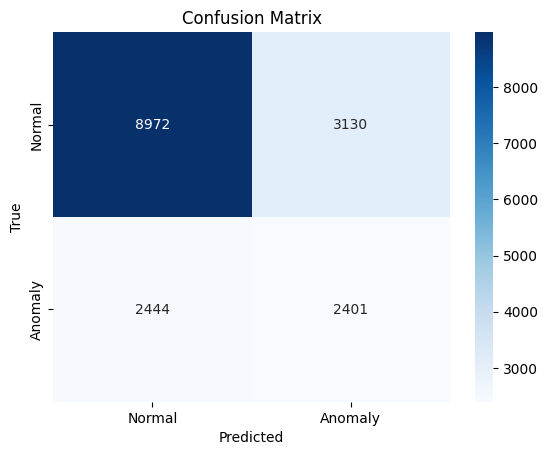